# Stochastic simulations for Platoon

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import pickle
import os
import sys
import numpy as np
import scipy
import CRPS.CRPS as pscore
import pandas as pd

sys.path.append('../')
from OpenACC.ASta_data_loader import load_df
from config import Config

plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "Arial"
matplotlib.rcParams['font.size'] = 22
matplotlib.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'cm'

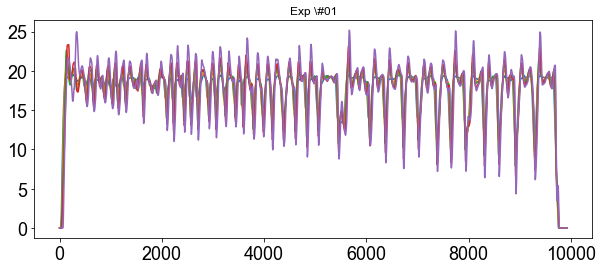

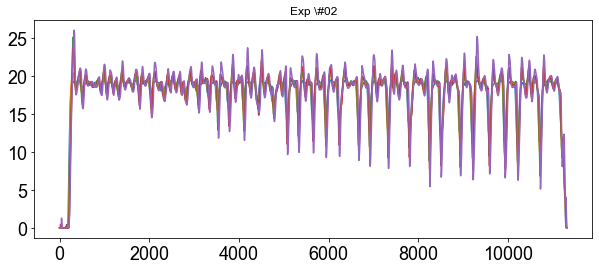

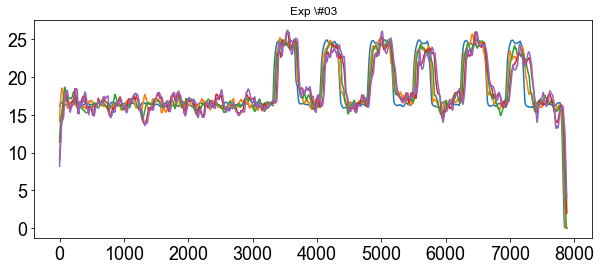

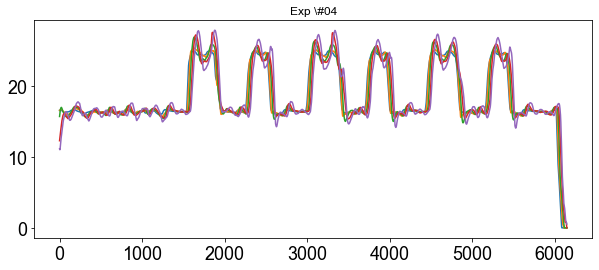

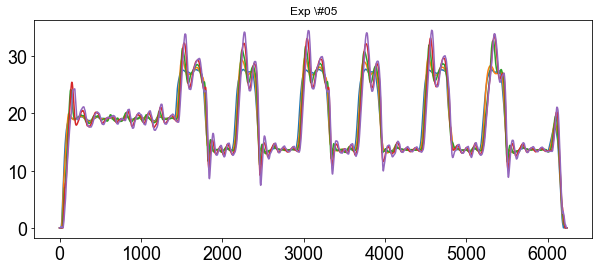

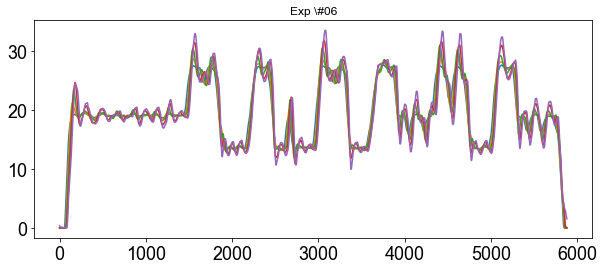

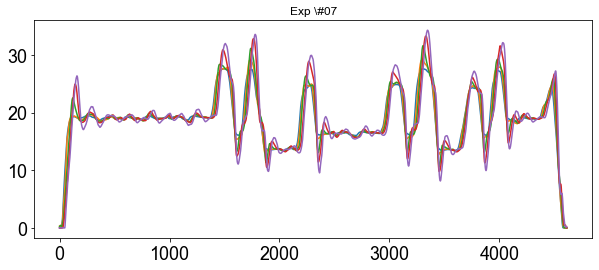

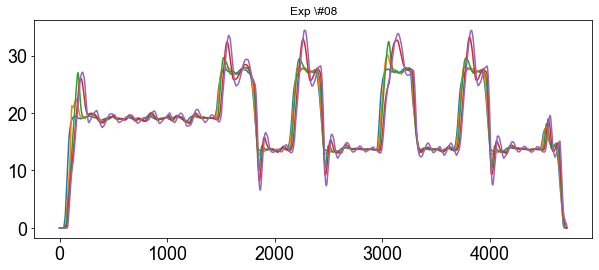

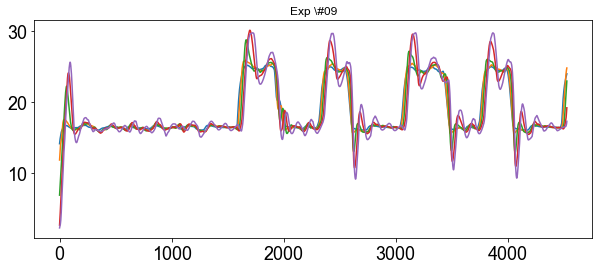

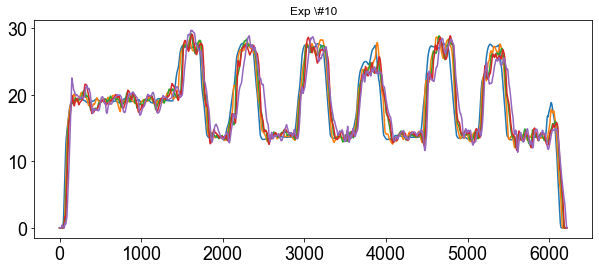

In [3]:
# Download the OpenACC dataset before running this block
for j in range(1,11):
    df = load_df(id=j)
    fig = plt.figure(figsize=(10, 4))
    for i in range(1,6):
        plt.plot(df['v{:01d}_kf'.format(i)].to_numpy())
    plt.title('Exp \#{:02d}'.format(j))

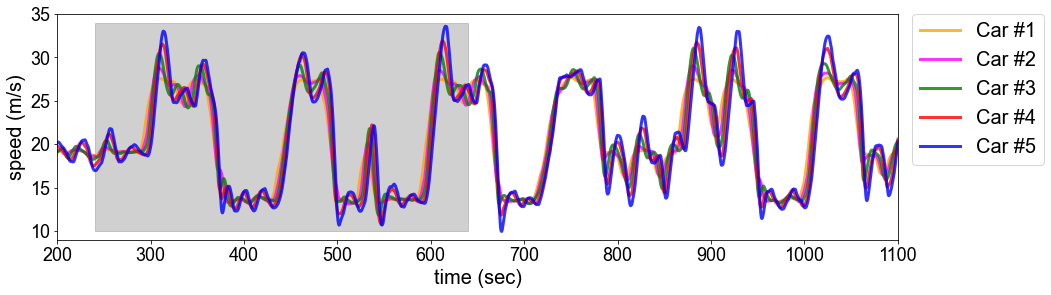

In [4]:
from matplotlib.patches import Rectangle

plt.rcParams["font.family"] = "Arial"
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'cm'

color_list=['orange', 'fuchsia','g','r','b']
j=6
df = load_df(id=j)
fig, ax = plt.subplots(figsize=(15, 4.5))

for i in range(1,6):
    N = df['v{:01d}_kf'.format(i)].to_numpy().shape[0]
    plt.plot(np.array(range(0, N))*Config.dt, df['v{:01d}_kf'.format(i)].to_numpy(),
             label='Car #{:01d}'.format(i), linewidth=3, alpha=0.8, color=color_list[i-1])

ax.add_patch(Rectangle([240,10], 400, 24, color='grey', alpha=0.37, edgecolor='none'))
plt.xlabel('time (sec)')
plt.ylabel('speed (m/s)')
plt.legend(bbox_to_anchor=(1.017, 1), loc='upper left', borderaxespad=0)
plt.xlim(200,1100)
plt.ylim(9,35)
plt.tight_layout()
# fig.savefig('../Figs/OpenACC_data.pdf', dpi=300)
plt.show()

Load trace ../PGM_OpenACC/cache/AR4_IDM_hierarchical.pkl : done!


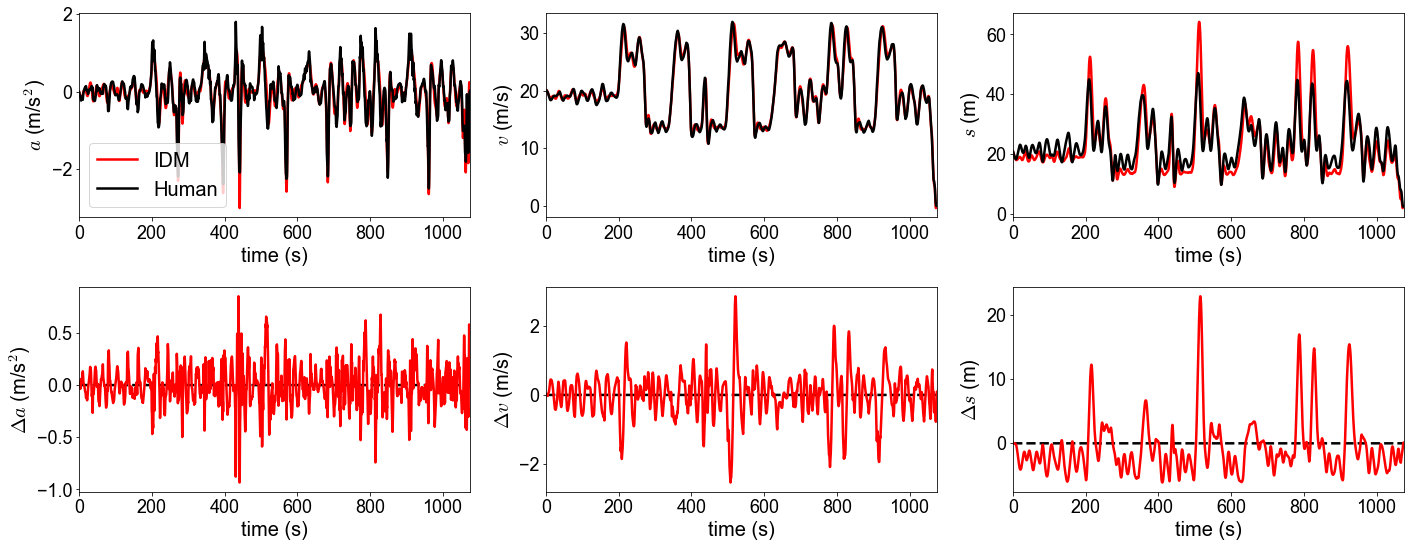

In [6]:
from sklearn.metrics import mean_squared_error
from scipy.stats import multivariate_normal

plt.rcParams["font.family"] = "Arial"
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'cm'

def IDM_a(VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA, s, vt, dv):
    sn = DSAFE + vt * TSAFE + vt * dv / (2 * np.sqrt(AMAX * AMIN))
    a = AMAX * (1 - (vt / VMAX) ** DELTA - (sn / s) ** 2)
    return a

def IDM_v(IDM_a, vt):
    return vt + IDM_a * Config.dt

def IDM_x(IDM_v, xt, vt):
    return xt + 0.5 * (IDM_v + vt) * Config.dt


def simulate(tr, sample_idx, print_values=False, mean=False):
    id_file = 6
    df = load_df(id=id_file)[500:]
    id_veh = 4
    
    driver_para = tr.posterior.mu_d[:,:,id_veh-2,:].mean(axis=0).mean(axis=0).to_numpy()
    driver_para *= [33, 2, 1.6, 1.5, 1.67]
    DELTA = 4 
    
    if print_values:
        print("Loading parameters for driver", str(id_veh))
        print(driver_para)
    
    x_leader = df['x{:01d}_kf'.format(id_veh-1)].to_numpy()
    x_follower  = df['x{:01d}_kf'.format(id_veh)].to_numpy()
    v_leader = df['v{:01d}_kf'.format(id_veh-1)].to_numpy()
    v_follower = df['v{:01d}_kf'.format(id_veh)].to_numpy()
    a_follower = df['a{:01d}_kf'.format(id_veh)].to_numpy()
    s_real  = df['IVS{:01d}'.format(id_veh-1)].to_numpy()

    N = x_leader.shape[0]

    T = np.array(range(0, N))*Config.dt

    x_follower_temp = x_follower[0]
    v_follower_temp = v_follower[0]

    x_follower_sim = np.zeros(N)
    s_follower_sim = np.zeros(N)
    v_follower_sim = np.zeros(N)
    a_follower_sim = np.zeros(N)

    v_follower_sim[0] = v_follower_temp
    s_follower_sim[0] = s_real[0]

    for t in range(1, N):
        x_leader_temp = x_leader[t-1]
        v_leader_temp = v_leader[t-1]

        s = x_leader_temp - x_follower_temp
        vt = v_follower_temp
        dv = v_follower_temp - v_leader_temp

        a_follower_temp = np.max((IDM_a(driver_para[0], driver_para[1], driver_para[2], driver_para[3], driver_para[4], DELTA, s, vt, dv), -3))
        v_follower_temp = IDM_v(a_follower_temp, vt)
        x_follower_temp  = IDM_x(v_follower_temp, x_follower_temp, vt)

        x_follower_sim[t] = x_follower_temp
        s_follower_sim[t] = s
        v_follower_sim[t] = v_follower_temp
        a_follower_sim[t-1] = a_follower_temp

    a_follower_sim[-1] = a_follower_sim[-2]

    return a_follower_sim, a_follower, v_follower_sim, v_follower, s_follower_sim, s_real, T


cache = "../PGM_OpenACC/cache/AR4_IDM_hierarchical.pkl"
fp = open(cache, 'rb')
tr_GP = pickle.load(fp)
fp.close()
print("Load trace", cache, ": done!")


fig, _ = plt.subplots(ncols=3, sharex=True, figsize=(20, 8))

linewidth_mean = 2.5
color_sim_mean = 'red'

a_follower_sim_mean_GP, a_follower, v_follower_sim_mean_GP, v_follower, s_follower_sim_mean_GP, s_real, T = simulate(tr_GP, 0, mean=True)

ax1 = plt.subplot(2,3,1)
plt.plot(T,a_follower_sim_mean_GP,'-', color=color_sim_mean, label='IDM', linewidth=linewidth_mean, alpha=1)
plt.plot(T,a_follower,'k-', label='Human', linewidth=linewidth_mean, alpha=1)
plt.xlabel('time (s)')
plt.ylabel('$a$ (m/s$^2$)')
plt.legend()

ax2 = plt.subplot(2,3,2)
plt.plot(T,v_follower_sim_mean_GP,'-', color=color_sim_mean, label='IDM', linewidth=linewidth_mean, alpha=1)
plt.plot(T,v_follower,'k-', label='Human', linewidth=linewidth_mean, alpha=1)
plt.xlabel('time (s)')
plt.ylabel('$v$ (m/s)')

ax3 = plt.subplot(2,3,3)
plt.plot(T,s_follower_sim_mean_GP,'-', color=color_sim_mean, label='IDM', linewidth=linewidth_mean, alpha=1)
plt.plot(T,s_real,'k-', label='Human', linewidth=linewidth_mean, alpha=1)
plt.xlabel('time (s)')
plt.ylabel('$s$ (m)')

ax4 = plt.subplot(2,3,4)
plt.plot(T, np.zeros_like(T), '--', color='k', label='0', linewidth=linewidth_mean, alpha=1)
plt.plot(T,a_follower_sim_mean_GP-a_follower,'-', color=color_sim_mean, label='GP-IDM: mean', linewidth=linewidth_mean, alpha=1)
plt.xlabel('time (s)')
plt.ylabel('$\Delta a$ (m/s$^2$)')

ax5 = plt.subplot(2,3,5)
plt.plot(T, np.zeros_like(T), '--', color='k', label='0', linewidth=linewidth_mean, alpha=1)
plt.plot(T,v_follower_sim_mean_GP-v_follower,'-', color=color_sim_mean, label='GP-IDM: mean', linewidth=linewidth_mean, alpha=1)

plt.xlabel('time (s)')
plt.ylabel('$\Delta v$ (m/s)')

ax6 = plt.subplot(2,3,6)
plt.plot(T, np.zeros_like(T), '--', color='k', label='0', linewidth=linewidth_mean, alpha=1)
plt.plot(T,s_follower_sim_mean_GP-s_real,'-', color=color_sim_mean, label='GP-IDM: mean', linewidth=linewidth_mean, alpha=1)

plt.xlabel('time (s)')
plt.ylabel('$\Delta s$ (m)')




ax1.set_xlim((0,T.max()))
ax2.set_xlim((0,T.max()))
ax3.set_xlim((0,T.max()))
ax4.set_xlim((0,T.max()))
ax5.set_xlim((0,T.max()))
ax6.set_xlim((0,T.max()))

plt.tight_layout()
plt.show()
# fig.savefig('../Figs/noniid.png', dpi=300)

# Hierarchical Model

# AR-IDM hierarchical

Load trace ../PGM_OpenACC/cache/AR4_IDM_hierarchical.pkl : done!
Load trace ../PGM_OpenACC/cache/Bayesian_IDM_hierarchical.pkl : done!
Load tracks ../Simulator/cache/OpenACC06_id2_AR4_hierarchical-sim_200.pkl : done!
Simulation: 20 / 200
Simulation: 40 / 200
Simulation: 60 / 200
Simulation: 80 / 200
Simulation: 100 / 200
Simulation: 120 / 200
Simulation: 140 / 200
Simulation: 160 / 200
Simulation: 180 / 200
Simulation: 200 / 200


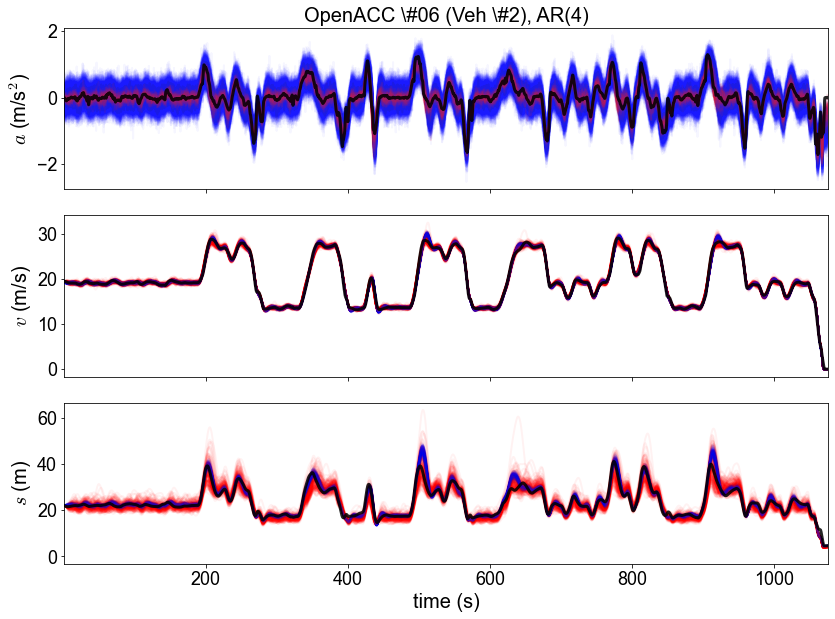

In [18]:
from sklearn.metrics import mean_squared_error
from scipy.stats import multivariate_normal
from sklearn.metrics.pairwise import rbf_kernel

import pickle
from pickle import UnpicklingError
import os
from os import path

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["font.family"] = "Arial"
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'cm'

def IDM_a(VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA, s, vt, dv):
    sn = DSAFE + vt * TSAFE + vt * dv / (2 * np.sqrt(AMAX * AMIN))
    a = AMAX * (1 - (vt / VMAX) ** DELTA - (sn / s) ** 2)
    return a

def IDM_v(IDM_a, vt):
    return vt + IDM_a * Config.dt

def IDM_x(IDM_v, xt, vt):
    return xt + 0.5 * (IDM_v + vt) * Config.dt

id_file = 6
id_veh = 2

def simulate(tr, sample_idx, d, print_values=False, mean=False, AR_flag=False):
    df = load_df(id=id_file)[500:]
    
    driver_para = tr.posterior.mu_d[:,:,id_veh-2,:].mean(axis=0).mean(axis=0).to_numpy()
    driver_para *= [33, 2, 1.6, 1.5, 1.67]
    
    DELTA = 4 
    
    if print_values:
        print("Loading parameters for driver", str(id_veh))
        print(driver_para)
    
    x_leader = df['x{:01d}_kf'.format(id_veh-1)].to_numpy()
    x_follower  = df['x{:01d}_kf'.format(id_veh)].to_numpy()
    v_leader = df['v{:01d}_kf'.format(id_veh-1)].to_numpy()
    v_follower = df['v{:01d}_kf'.format(id_veh)].to_numpy()
    a_follower = df['a{:01d}_kf'.format(id_veh)].to_numpy()
    s_real  = df['IVS{:01d}'.format(id_veh-1)].to_numpy()
    
    if AR_flag:
        rho = tr.posterior.rho[:,:,:].mean(axis=0).mean(axis=0).to_numpy()

    N = x_leader.shape[0]

    T = np.array(range(0, N))*Config.dt

    x_follower_temp = x_follower[d]
    v_follower_temp = v_follower[d]

    x_follower_sim = np.zeros(N)
    s_follower_sim = np.zeros(N)
    v_follower_sim = np.zeros(N)
    a_follower_sim = np.zeros(N)

    v_follower_sim[0:d+1] = v_follower[0:d+1]
    s_follower_sim[0:d+1] = s_real[0:d+1]
    x_follower_sim[0:d+1] = x_follower[0:d+1]
    a_follower_sim[0:d] = a_follower[0:d]  
    
    if AR_flag:
        a_AR_sim = np.random.normal(0, tr.posterior.s_a.mean(axis=0).mean(axis=0), d)

    for t in range(d+1, N):
        x_leader_temp = x_leader[t-1]
        v_leader_temp = v_leader[t-1]
        
        s = x_leader_temp - x_follower_temp

        vt = v_follower_temp
        dv = v_follower_temp - v_leader_temp
        
        if AR_flag:
            a_AR_sim_temp = (rho * a_AR_sim).sum() + np.random.normal(0, tr.posterior.s_a.mean(axis=0).mean(axis=0))
        else:
            a_AR_sim_temp = np.random.normal(0, tr.posterior.s_a.mean())
#         print('t:',t,'a_AR_sim_temp:', a_AR_sim_temp,'IDM:',IDM_a(driver_para[0], driver_para[1], driver_para[2], driver_para[3], driver_para[4], DELTA, s, vt, dv),'a_real:',a_follower[t])
        a_follower_temp = np.max((a_AR_sim_temp + IDM_a(driver_para[0], driver_para[1], driver_para[2], driver_para[3], driver_para[4], DELTA, s, vt, dv), -3))
        v_follower_temp = np.max((IDM_v(a_follower_temp, vt), 0))
        x_follower_temp  = IDM_x(v_follower_temp, x_follower_temp, vt)

        x_follower_sim[t] = x_follower_temp
        s_follower_sim[t] = s
        v_follower_sim[t] = v_follower_temp
        a_follower_sim[t-1] = a_follower_temp
        if AR_flag:
            a_AR_sim[:-1] = a_AR_sim[1:]
            a_AR_sim[-1] = a_AR_sim_temp

    a_follower_sim[-1] = a_follower_sim[-2]

    return a_follower_sim, a_follower, v_follower_sim, v_follower, s_follower_sim, s_real, T
    
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(12, 9)) #(12, 7)

print_values = False
sample_num = 200
counter = 0

linewidth = 2.
linewidth_mean = 1.5
linewidth_gt = 3
color_sim = 'red'
color_sim_mean = 'yellow'
color_sim_B = 'blue'
color_sim_mean_B = 'fuchsia'
color_sim_gt = 'k'
alpha = 0.05

RMSE_ACC_AR = np.zeros(sample_num)
RMSE_VEL_AR = np.zeros(sample_num)
RMSE_GAP_AR = np.zeros(sample_num)
RMSE_ACC_B = np.zeros(sample_num)
RMSE_VEL_B = np.zeros(sample_num)
RMSE_GAP_B = np.zeros(sample_num)

d = 4
ax1.set_title('OpenACC \#{:02d} (Veh \#{:01d}), AR({:01d})'.format(id_file,id_veh,d), fontsize=20)

base_path = '../data/highD/'

cache = "../PGM_OpenACC/cache/AR{:01d}_IDM_hierarchical.pkl".format(d)
with open(cache, 'rb') as fp:
    tr_AR = pickle.load(fp)
print("Load trace", cache, ": done!")

cache = "../PGM_OpenACC/cache/Bayesian_IDM_hierarchical.pkl"
fp = open(cache, 'rb')
tr_B = pickle.load(fp)
fp.close()
print("Load trace", cache, ": done!")

cache = "../Simulator/cache/OpenACC{:02d}_id{:01d}_AR{:01d}_hierarchical-sim_".format(id_file,id_veh,d) + str(sample_num) + ".pkl"

a_follower_sim_mean_AR, a_follower, v_follower_sim_mean_AR, v_follower, s_follower_sim_mean_AR, s_real, T = simulate(tr_AR, 0, d=d, print_values=print_values, mean=True, AR_flag=True)
a_follower_sim_mean_B, _, v_follower_sim_mean_B, _, s_follower_sim_mean_B, _, _ = simulate(tr_B, 0, d=1, print_values=print_values, mean=True)

if path.exists(cache):
    try:
        fp = open(cache, 'rb')
        tracks = pickle.load(fp)
        fp.close()
        print("Load tracks", cache, ": done!")
    except UnpicklingError:
        os.remove(cache)
        print('Removed broken cache:', cache)
else:
    tracks = [None]*sample_num

    
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

for sample_idx in np.random.choice(range(2000), sample_num, replace=False): #range(sample_num):#
    if not path.exists(cache):
        a_follower_sim_AR, _, v_follower_sim_AR, _, s_follower_sim_AR, _, T = simulate(tr_AR, sample_idx, d=d, print_values=print_values, mean=False, AR_flag=True)
        a_follower_sim_B, _, v_follower_sim_B, _, s_follower_sim_B, _, T = simulate(tr_B, sample_idx, d=1, print_values=print_values, mean=False)
        
        tracks[counter] = {
            'a_follower_sim_AR': a_follower_sim_AR,
            'v_follower_sim_AR': v_follower_sim_AR,
            's_follower_sim_AR': s_follower_sim_AR,
            'a_follower_sim_B': a_follower_sim_B,
            'v_follower_sim_B': v_follower_sim_B,
            's_follower_sim_B': s_follower_sim_B,
        }
    else:
        a_follower_sim_AR = tracks[counter]['a_follower_sim_AR']
        v_follower_sim_AR = tracks[counter]['v_follower_sim_AR']
        s_follower_sim_AR = tracks[counter]['s_follower_sim_AR']
        a_follower_sim_B = tracks[counter]['a_follower_sim_B']
        v_follower_sim_B = tracks[counter]['v_follower_sim_B']
        s_follower_sim_B = tracks[counter]['s_follower_sim_B']
    
    counter += 1
    ######################################################################################################
    if counter % 1==0:
        plt.subplot(3,1,1)
        plt.plot(T[d:],a_follower_sim_B[d:],'-', color=lighten_color(color_sim_B, .9), linewidth=linewidth, alpha=.8*alpha)
        plt.plot(T[d:],a_follower_sim_AR[d:],'-', color=lighten_color(color_sim, .9), linewidth=0.8*linewidth, alpha=2*alpha)

    plt.subplot(3,1,2)
    plt.plot(T[d:],v_follower_sim_AR[d:],'-', color=color_sim, linewidth=linewidth, alpha=alpha)
    plt.plot(T[d:],v_follower_sim_B[d:],'-', color=color_sim_B, linewidth=linewidth, alpha=alpha)

    plt.subplot(3,1,3)
    plt.plot(T[d:],s_follower_sim_AR[d:],'-', color=color_sim, linewidth=linewidth, alpha=alpha)
    plt.plot(T[d:],s_follower_sim_B[d:],'-', color=color_sim_B, linewidth=linewidth, alpha=alpha)
    if counter % 20==0:
        print("Simulation:", counter, "/", sample_num)

if not path.exists(cache):
    output_file = open(cache, 'wb')
    pickle.dump(tracks, output_file)
    output_file.close()
    print("Generated and Saved", output_file, ": done!")

#########################################
plt.subplot(3,1,1)
plt.plot(T[d:],a_follower[d:],'-', color=color_sim_gt,label='Ground truth', linewidth=linewidth_gt, alpha=0.85)
plt.ylabel('$a$ (m/s$^2$)')

plt.subplot(3,1,2)
plt.plot(T[d:],v_follower[d:],'-', color=color_sim_gt,label='Ground truth', linewidth=linewidth_gt, alpha=0.85)
plt.ylabel('$v$ (m/s)')

plt.subplot(3,1,3)
plt.plot(T[d:],s_real[d:],'-', color=color_sim_gt,label='Ground truth', linewidth=linewidth_gt, alpha=0.85)
plt.xlabel('time (s)')
plt.ylabel('$s$ (m)')

plt.subplot(3,1,1)
plt.plot(0,0,'-', color=color_sim, label='AR-IDM: samples', linewidth=linewidth, alpha=1)
plt.plot(0,0,'-', color=color_sim_B, label='Bayesian IDM: samples', linewidth=linewidth, alpha=1)

plt.plot(0,0,'--', color='w', label='(Hierarchical models)', linewidth=linewidth_mean, alpha=0)

plt.subplot(3,1,2)
plt.plot(0,0,'-', color=color_sim, label='AR-IDM: samples', linewidth=linewidth, alpha=1)
plt.plot(0,0,'-', color=color_sim_B, label='Bayesian IDM: samples', linewidth=linewidth, alpha=1)

plt.subplot(3,1,3)
plt.plot(0,0,'-', color=color_sim, label='AR-IDM: samples', linewidth=linewidth, alpha=1)
plt.plot(0,0,'-', color=color_sim_B, label='Bayesian IDM: samples', linewidth=linewidth, alpha=1)

ax1.set_xlim((d*Config.dt,T.max()))
ax2.set_xlim((d*Config.dt,T.max()))
ax3.set_xlim((d*Config.dt,T.max()))

ax1.set_rasterized(True)
ax2.set_rasterized(True)
ax3.set_rasterized(True)

plt.tight_layout()
# fig.savefig('../Figs/OpenACC{:02d}_id{:01d}_AR{:01d}_hierarchical_stochastic_sim.pdf'.format(id_file,id_veh,d), dpi=300)
plt.show()

# Platoon Simulation

Load trace ../PGM_OpenACC/cache/AR4_IDM_hierarchical.pkl : done!
Load trace ../PGM_OpenACC/cache/Bayesian_IDM_hierarchical.pkl : done!
Simulation: 20 / 500
Simulation: 40 / 500
Simulation: 60 / 500
Simulation: 80 / 500
Simulation: 100 / 500
Simulation: 120 / 500
Simulation: 140 / 500
Simulation: 160 / 500
Simulation: 180 / 500
Simulation: 200 / 500
Simulation: 220 / 500
Simulation: 240 / 500
Simulation: 260 / 500
Simulation: 280 / 500
Simulation: 300 / 500
Simulation: 320 / 500
Simulation: 340 / 500
Simulation: 360 / 500
Simulation: 380 / 500
Simulation: 400 / 500
Simulation: 420 / 500
Simulation: 440 / 500
Simulation: 460 / 500
Simulation: 480 / 500
Simulation: 500 / 500
Generated and Saved <_io.BufferedWriter name='../Simulator/cache/OpenACC06_AR4_Platoon_t1200_T2000_N500.pkl'> : done!


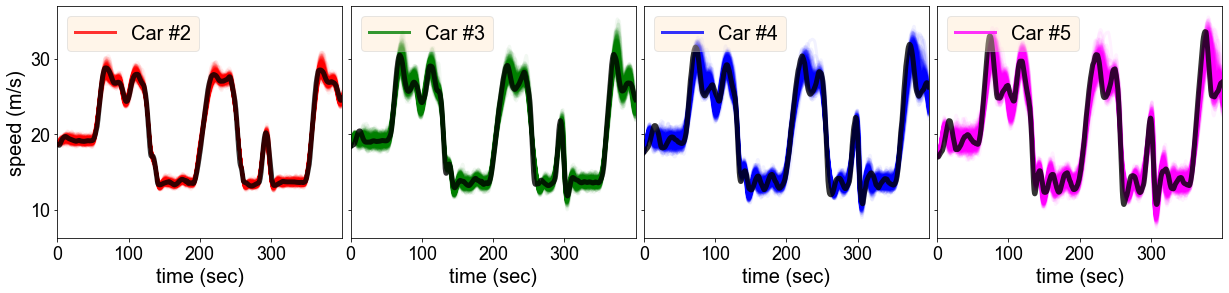

In [17]:
import matplotlib.pyplot as plt
import matplotlib
import pickle
from pickle import UnpicklingError
import os
from os import path
import sys
import numpy as np

import warnings

warnings.filterwarnings("ignore")

sys.path.append('../')
from OpenACC.ASta_data_loader import load_df
from config import Config

plt.rcParams["font.family"] = "Arial"
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'cm'


def IDM_a(VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA, s, vt, dv):
    sn = DSAFE + vt * TSAFE + vt * dv / (2 * np.sqrt(AMAX * AMIN))
    a = AMAX * (1 - (vt / VMAX) ** DELTA - (sn / s) ** 2)
    return a


def IDM_v(IDM_a, vt):
    return vt + IDM_a * Config.dt


def IDM_x(IDM_v, xt, vt):
    return xt + 0.5 * (IDM_v + vt) * Config.dt


id_file = 6
total_length = 2000
sample_num = 500
d = 4
t0 = 1200

counter = 0

linewidth = 3.
linewidth_mean = 2
linewidth_gt = 5
color_sim = ['red', 'green', 'blue', 'magenta']
color_sim_mean = 'yellow'
color_sim_B = 'blue'
color_sim_mean_B = 'fuchsia'
color_sim_gt = 'k'
alpha = 0.05


def simulate(tr, sample_idx, d, t, AR_flag=False):
    df = load_df(id=id_file)[t:t + total_length]
    DELTA = 4
    x_leader = np.zeros((4, total_length))
    x_follower = np.zeros((4, total_length))
    v_leader = np.zeros((4, total_length))
    v_follower = np.zeros((4, total_length))
    a_follower = np.zeros((4, total_length))
    s_real = np.zeros((4, total_length))
    x_follower_sim = np.zeros((4, total_length))
    v_follower_sim = np.zeros((4, total_length))
    a_follower_sim = np.zeros((4, total_length))
    s_follower_sim = np.zeros((4, total_length))

    for id_veh in range(2, 6):
        driver_para = tr.posterior.mu_d[:, :, id_veh - 2, :].mean(axis=0).mean(axis=0).to_numpy()
        driver_para *= [33, 2, 1.6, 1.5, 1.67]
        
        x_leader[id_veh - 2, :] = df['x{:01d}_kf'.format(id_veh - 1)].to_numpy()
        x_follower[id_veh - 2, :] = df['x{:01d}_kf'.format(id_veh)].to_numpy()
        v_leader[id_veh - 2, :] = df['v{:01d}_kf'.format(id_veh - 1)].to_numpy()
        v_follower[id_veh - 2, :] = df['v{:01d}_kf'.format(id_veh)].to_numpy()
        a_follower[id_veh - 2, :] = df['a{:01d}_kf'.format(id_veh)].to_numpy()
        s_real[id_veh - 2, :] = df['IVS{:01d}'.format(id_veh - 1)].to_numpy()

        if AR_flag:
            rho = tr.posterior.rho[:, :, :].mean(axis=0).mean(axis=0).to_numpy()

        N = total_length

        x_follower_temp = x_follower[id_veh - 2, d]
        v_follower_temp = v_follower[id_veh - 2, d]

        v_follower_sim[id_veh - 2, 0:d + 1] = v_follower[id_veh - 2, 0:d + 1]
        s_follower_sim[id_veh - 2, 0:d + 1] = s_real[id_veh - 2, 0:d + 1]
        x_follower_sim[id_veh - 2, 0:d + 1] = x_follower[id_veh - 2, 0:d + 1]
        a_follower_sim[id_veh - 2, 0:d] = a_follower[id_veh - 2, 0:d]

        if AR_flag:
            a_AR_sim = np.random.normal(0, tr.posterior.s_a.mean(axis=0).mean(axis=0), d)

        for t in range(d + 1, N):
            if id_veh == 2:
                x_leader_temp = x_leader[id_veh - 2, t - 1]
                v_leader_temp = v_leader[id_veh - 2, t - 1]
            else:
                x_leader_temp = x_follower_sim[id_veh - 3, t - 1]
                v_leader_temp = v_follower_sim[id_veh - 3, t - 1]

            s = x_leader_temp - x_follower_temp

            vt = v_follower_temp
            dv = v_follower_temp - v_leader_temp

            if AR_flag:
                a_AR_sim_temp = (rho * a_AR_sim).sum() + np.random.normal(0, tr.posterior.s_a.mean(axis=0).mean(axis=0))
            else:
                a_AR_sim_temp = np.random.normal(0, tr.posterior.s_a.mean())
            # print('t:',t,'a_AR_sim_temp:', a_AR_sim_temp,'IDM:',IDM_a(driver_para[0], driver_para[1], driver_para[2], driver_para[3], driver_para[4], DELTA, s, vt, dv),'a_real:',a_follower[t])
            a_follower_temp = np.max(
                (a_AR_sim_temp + IDM_a(driver_para[0], driver_para[1], driver_para[2], driver_para[3],
                                       driver_para[4], DELTA, s, vt, dv), -18))
            v_follower_temp = np.max((IDM_v(a_follower_temp, vt), 0))
            x_follower_temp = IDM_x(v_follower_temp, x_follower_temp, vt)

            x_follower_sim[id_veh - 2, t] = x_follower_temp
            s_follower_sim[id_veh - 2, t] = s
            v_follower_sim[id_veh - 2, t] = v_follower_temp
            a_follower_sim[id_veh - 2, t - 1] = a_follower_temp
            if AR_flag:
                a_AR_sim[:-1] = a_AR_sim[1:]
                a_AR_sim[-1] = a_AR_sim_temp

        a_follower_sim[id_veh - 2, -1] = a_follower_sim[id_veh - 2, -2]

    return a_follower_sim, a_follower, v_follower_sim, v_follower, s_follower_sim, s_real


fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=True, figsize=(17, 4))  # (12, 7)

base_path = '../data/highD/'

cache = "../PGM_OpenACC/cache/AR{:01d}_IDM_hierarchical.pkl".format(d)
with open(cache, 'rb') as fp:
    tr_AR = pickle.load(fp)
print("Load trace", cache, ": done!")

cache = "../PGM_OpenACC/cache/Bayesian_IDM_hierarchical.pkl"
fp = open(cache, 'rb')
tr_B = pickle.load(fp)
fp.close()
print("Load trace", cache, ": done!")

cache = "../Simulator/cache/OpenACC{:02d}_AR{:01d}_Platoon_t{:d}_T{:d}_N{:d}.pkl".format(id_file, d, t0, total_length,
                                                                                         sample_num)


if path.exists(cache):
    try:
        fp = open(cache, 'rb')
        tracks = pickle.load(fp)
        fp.close()
        print("Load tracks", cache, ": done!")
    except UnpicklingError:
        os.remove(cache)
        print('Removed broken cache:', cache)
else:
    tracks = [None] * sample_num


def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


T = np.array(range(0, total_length)) * Config.dt

_, a_follower, _, v_follower, _, s_real = simulate(tr_AR, 0, d=d, t=t0, AR_flag=False)

for sample_idx in np.random.choice(range(2000), sample_num, replace=False):  # range(sample_num):#
    if not path.exists(cache):
        a_follower_sim_AR, a_follower, v_follower_sim_AR, v_follower, \
        s_follower_sim_AR, s_real = simulate(tr_AR, sample_idx, d=d, t=t0, AR_flag=True)

        tracks[counter] = {
            'a_follower_sim_AR': a_follower_sim_AR,
            'v_follower_sim_AR': v_follower_sim_AR,
            's_follower_sim_AR': s_follower_sim_AR,
        }
    else:
        a_follower_sim_AR = tracks[counter]['a_follower_sim_AR']
        v_follower_sim_AR = tracks[counter]['v_follower_sim_AR']
        s_follower_sim_AR = tracks[counter]['s_follower_sim_AR']

    counter += 1

    ######################################################################################################
    for id in range(4):
        plt.subplot(1, 4, id + 1)
        plt.plot(T, v_follower_sim_AR[id, :], '-', color=color_sim[id], linewidth=linewidth, alpha=alpha)

    if counter % 20 == 0:
        print("Simulation:", counter, "/", sample_num)

if not path.exists(cache):
    output_file = open(cache, 'wb')
    pickle.dump(tracks, output_file)
    output_file.close()
    print("Generated and Saved", output_file, ": done!")

#########################################
for id in range(4):
    plt.subplot(1, 4, id + 1)
    plt.plot(T, v_follower[id, :], '-', color=color_sim_gt, linewidth=linewidth_gt, alpha=0.8)
    # label = 'Car \#{:d}'.format(id + 2),
    plt.plot(0, v_follower[id, 0], '-', label='Car #{:d}'.format(id + 2), color=color_sim[id], linewidth=linewidth,
             alpha=0.8)
    plt.legend(loc='upper left', framealpha=0.37, facecolor='bisque', edgecolor='silver')
    plt.xlabel('time (sec)')

ax1.set_ylabel('speed (m/s)')
ax1.set_xlim((0 * Config.dt, T.max()))
ax2.set_xlim((0 * Config.dt, T.max()))
ax3.set_xlim((0 * Config.dt, T.max()))
ax4.set_xlim((0 * Config.dt, T.max()))

ax1.set_rasterized(True)
ax2.set_rasterized(True)
ax3.set_rasterized(True)
ax4.set_rasterized(True)

plt.tight_layout(rect=(-0.016, -0.07, 1.012, 1.05), w_pad=0.16)

fig.savefig(
    "../Figs/OpenACC{:02d}_AR{:01d}_Platoon_t{:d}_T{:d}_N{:d}.pdf".format(id_file, d, t0, total_length, sample_num),
    dpi=300)

plt.show()